In [1]:
# import
import numpy as np
import numpy.linalg as LA
import sys
import time

In [2]:
# 引数(今回は仮置き)
args = sys.argv
defect_x = 1
defect_y = 1

In [3]:
print('start '+str(defect_x)+' '+str(defect_y))

start 1 1


In [4]:
# 欠陥node特定
base_point = defect_x + 51*defect_y
defect_node = base_point + 1 + 51

In [5]:
# const
ele_size = 1/2*0.02*0.02
poi = 0.2
e = 1000000000*37
th = 1.0
row = 2400
delta_t = 0.0000004
pow_delta_t = delta_t*delta_t
total_time = 0.001
total_step = int(total_time/delta_t)
load = 100 #外力最大値
load_time = 0.00001
load_step = int(load_time/delta_t)
load_diff = load/load_step
alpha = 0.58332

In [20]:
# ファイル読み込み:nodeとeleの設定
node_file = "four_holes_"+str(defect_x)+"_"+str(defect_y)+".1.node"
ele_file = "four_holes_"+str(defect_x)+"_"+str(defect_y)+".1.ele"
node_path = "../triangle_master/poly/"+node_file
ele_path = "../triangle_master/poly/"+ele_file
with open(node_path) as f_node:
    s_line = f_node.readline()
    number_list = s_line.split()
    nnode_str = number_list[0]
    nnode = int(nnode_str)
    position = np.zeros((nnode, 2), dtype=np.float)
    for i in range(nnode):
        s_line = f_node.readline()
        number_list = s_line.split()
        x_str = number_list[1]
        y_str = number_list[2]
        x = float(x_str)
        y = float(y_str)
        position[i][0] = x*0.02
        position[i][1] = y*0.02
with open(ele_path) as f_ele:
    s_line = f_ele.readline()
    number_list = s_line.split()
    nele_str = number_list[0]
    nele = int(nele_str)
    eles = np.zeros((nele, 3), dtype=np.int64)
    for h in range(nele):
        s_line = f_ele.readline()
        number_list = s_line.split()
        i_str = number_list[1]
        j_str = number_list[2]
        k_str = number_list[3]
        i = int(i_str)
        j = int(j_str)
        k = k_str
        eles[h][0] = i
        eles[h][1] = j
        eles[h][2] = k

In [21]:
# 全体剛性行列と全体質量行列・全体集中質量行列の宣言
kt_with_defect = np.zeros((2*nnode, 2*nnode))
mt_with_defect = np.zeros((2*nnode, 2*nnode))
imt_with_defect = np.zeros((2*nnode, 2*nnode))
kt = np.zeros((2*(nnode-1), 2*(nnode-1)))
mt = np.zeros((2*(nnode-1), 2*(nnode-1)))
imt = np.zeros((2*(nnode-1), 2*(nnode-1)))

In [22]:
# 剛性行列と質量行列計算の定義
def calc_ke(ele, position, kt):
    i = ele[0]
    j = ele[1]
    k = ele[2]
    xi = position[i-1][0]
    yi = position[i-1][1]
    xj = position[j-1][0]
    yj = position[j-1][1]
    xk = position[k-1][0]
    yk = position[k-1][1]
    # ひずみ-変位関係
    b = np.zeros((3, 6))
    b[0][0] = yj-yk
    b[0][2] = yk-yi
    b[0][4] = yi-yj
    b[1][1] = xk-xj
    b[1][3] = xi-xk
    b[1][5] = xj-xi
    b[2][0] = xk-xj
    b[2][1] = yj-yk
    b[2][2] = xi-xk
    b[2][3] = yk-yi
    b[2][4] = xj-xi
    b[2][5] = yi-yj
    b=b/2/ele_size
    # 応力-ひずみ関係
    d = np.zeros((3, 3))
    d[0][0] = 1 - poi
    d[0][1] = poi
    d[1][0] = poi
    d[1][1] = 1 - poi
    d[2][2] = (1-2*poi)/2
    d = d*e/(1+poi)/(1-2*poi)
    ke = th*ele_size*np.dot(np.dot(b.T, d), b)
    # 全体剛性行列への組み込み
    kt[2*i-1-1][2*i-1-1] += ke[1-1][1-1]
    kt[2*i-1-1][2*i-1] += ke[1-1][2-1]
    kt[2*i-1][2*i-1-1] += ke[2-1][1-1]
    kt[2*i-1][2*i-1] += ke[2-1][2-1]
    kt[2*i-1-1][2*j-1-1] += ke[1-1][3-1]
    kt[2*i-1-1][2*j-1] += ke[1-1][4-1]
    kt[2*i-1][2*j-1-1] += ke[2-1][3-1]
    kt[2*i-1][2*j-1] += ke[2-1][4-1]
    kt[2*i-1-1][2*k-1-1] += ke[1-1][5-1]
    kt[2*i-1-1][2*k-1] += ke[1-1][6-1]
    kt[2*i-1][2*k-1-1] += ke[2-1][5-1]
    kt[2*i-1][2*k-1] += ke[2-1][6-1]

    kt[2*j-1-1][2*i-1-1] += ke[3-1][1-1]
    kt[2*j-1-1][2*i-1] += ke[3-1][2-1]
    kt[2*j-1][2*i-1-1] += ke[4-1][1-1]
    kt[2*j-1][2*i-1] += ke[4-1][2-1]
    kt[2*j-1-1][2*j-1-1] += ke[3-1][3-1]
    kt[2*j-1-1][2*j-1] += ke[3-1][4-1]
    kt[2*j-1][2*j-1-1] += ke[4-1][3-1]
    kt[2*j-1][2*j-1] += ke[4-1][4-1]
    kt[2*j-1-1][2*k-1-1] += ke[3-1][5-1]
    kt[2*j-1-1][2*k-1] += ke[3-1][6-1]
    kt[2*j-1][2*k-1-1] += ke[4-1][5-1]
    kt[2*j-1][2*k-1] += ke[4-1][6-1]

    kt[2*k-1-1][2*i-1-1] += ke[5-1][1-1]
    kt[2*k-1-1][2*i-1] += ke[5-1][2-1]
    kt[2*k-1][2*i-1-1] += ke[6-1][1-1]
    kt[2*k-1][2*i-1] += ke[6-1][2-1]
    kt[2*k-1-1][2*j-1-1] += ke[5-1][3-1]
    kt[2*k-1-1][2*j-1] += ke[5-1][4-1]
    kt[2*k-1][2*j-1-1] += ke[6-1][3-1]
    kt[2*k-1][2*j-1] += ke[6-1][4-1]
    kt[2*k-1-1][2*k-1-1] += ke[5-1][5-1]
    kt[2*k-1-1][2*k-1] += ke[5-1][6-1]
    kt[2*k-1][2*k-1-1] += ke[6-1][5-1]
    kt[2*k-1][2*k-1] += ke[6-1][6-1]

    return kt

def calc_me(ele, mt):
    i = ele[0]
    j = ele[1]
    k = ele[2]
    me = np.zeros((6, 6))
    me[0][0] = 1/6
    me[0][2] = 1/12
    me[0][4] = 1/12
    me[1][1] = 1/6
    me[1][3] = 1/12
    me[1][5] = 1/12
    me[2][0] = 1/12
    me[2][2] = 1/6
    me[2][4] = 1/12
    me[3][1] = 1/12
    me[3][3] = 1/6
    me[3][5] = 1/12
    me[4][0] = 1/12
    me[4][2] = 1/12
    me[4][4] = 1/6
    me[5][1] = 1/12
    me[5][3] = 1/12
    me[5][5] = 1/6
    me = ele_size*th*row*me
    # 全体質量行列への組み込み
    mt[2*i-1-1][2*i-1-1] += me[1-1][1-1]
    mt[2*i-1-1][2*i-1] += me[1-1][2-1]
    mt[2*i-1][2*i-1-1] += me[2-1][1-1]
    mt[2*i-1][2*i-1] += me[2-1][2-1]
    mt[2*i-1-1][2*j-1-1] += me[1-1][3-1]
    mt[2*i-1-1][2*j-1] += me[1-1][4-1]
    mt[2*i-1][2*j-1-1] += me[2-1][3-1]
    mt[2*i-1][2*j-1] += me[2-1][4-1]
    mt[2*i-1-1][2*k-1-1] += me[1-1][5-1]
    mt[2*i-1-1][2*k-1] += me[1-1][6-1]
    mt[2*i-1][2*k-1-1] += me[2-1][5-1]
    mt[2*i-1][2*k-1] += me[2-1][6-1]

    mt[2*j-1-1][2*i-1-1] += me[3-1][1-1]
    mt[2*j-1-1][2*i-1] += me[3-1][2-1]
    mt[2*j-1][2*i-1-1] += me[4-1][1-1]
    mt[2*j-1][2*i-1] += me[4-1][2-1]
    mt[2*j-1-1][2*j-1-1] += me[3-1][3-1]
    mt[2*j-1-1][2*j-1] += me[3-1][4-1]
    mt[2*j-1][2*j-1-1] += me[4-1][3-1]
    mt[2*j-1][2*j-1] += me[4-1][4-1]
    mt[2*j-1-1][2*k-1-1] += me[3-1][5-1]
    mt[2*j-1-1][2*k-1] += me[3-1][6-1]
    mt[2*j-1][2*k-1-1] += me[4-1][5-1]
    mt[2*j-1][2*k-1] += me[4-1][6-1]

    mt[2*k-1-1][2*i-1-1] += me[5-1][1-1]
    mt[2*k-1-1][2*i-1] += me[5-1][2-1]
    mt[2*k-1][2*i-1-1] += me[6-1][1-1]
    mt[2*k-1][2*i-1] += me[6-1][2-1]
    mt[2*k-1-1][2*j-1-1] += me[5-1][3-1]
    mt[2*k-1-1][2*j-1] += me[5-1][4-1]
    mt[2*k-1][2*j-1-1] += me[6-1][3-1]
    mt[2*k-1][2*j-1] += me[6-1][4-1]
    mt[2*k-1-1][2*k-1-1] += me[5-1][5-1]
    mt[2*k-1-1][2*k-1] += me[5-1][6-1]
    mt[2*k-1][2*k-1-1] += me[6-1][5-1]
    mt[2*k-1][2*k-1] += me[6-1][6-1]

    return mt

def calc_ime(ele, imt):
    i = ele[0]
    j = ele[1]
    k = ele[2]
    ime = np.zeros((6, 6))
    for h in range(6):
        ime[h][h] = 1/3
    ime = ele_size*th*row*ime
    imt[2*i-1-1][2*i-1-1] += ime[1-1][1-1]
    imt[2*i-1][2*i-1] += ime[2-1][2-1]
    imt[2*j-1-1][2*j-1-1] += ime[3-1][3-1]
    imt[2*j-1][2*j-1] += ime[4-1][4-1]
    imt[2*k-1-1][2*k-1-1] += ime[5-1][5-1]
    imt[2*k-1][2*k-1] += ime[6-1][6-1]
    return imt

In [23]:
# 合成行列と質量行列の組み込み繰り返し
for h in range(nele):
    ele = eles[h]
    kt_with_defect = calc_ke(ele, position, kt_with_defect)
    mt_with_defect = calc_me(ele, mt_with_defect)
    imt_with_defect = calc_ime(ele, imt_with_defect)

In [10]:
# 欠陥ノードを抜く(mtは使わないため省略)
#kt作成
for h in range(2*nnode):
    for hh in range(2*nnode):
        if h < 2*defect_node:
            if hh < 2*defect_node:
                kt[h][hh] = kt_with_defect[h][hh]
            elif hh == 2*defect_node:
                continue
            elif hh == 2*defect_node+1:
                continue
            else:
                kt[h][hh-2] = kt_with_defect[h][hh]
        elif h == 2*defect_node:
            continue
        elif h == 2*defect_node+1:
            continue
        else:
            if hh < 2*defect_node:
                kt[h-2][hh] = kt_with_defect[h][hh]
            elif hh == 2*defect_node:
                continue
            elif hh == 2*defect_node+1:
                continue
            else:
                kt[h-2][hh-2] = kt_with_defect[h][hh]
#imt作成
for h in range(2*nnode):
    if h < 2*defect_node:
        imt[h][h] = imt_with_defect[h][h]
    elif h == 2*defect_node:
        continue
    elif h == 2*defect_node+1:
        continue
    else:
        imt[h-2][h-2] = imt_with_defect[h][h]


In [14]:
# 外力生成(線形の増減)(左辺中心3点に荷重がかかるとする)(1辺51点)(positionから判断するよう変更)
ft = np.zeros((total_step, 2*(nnode-1), 1))
point1 = 1224
point2 = 1275
point3 = 1326
if point1 > defect_node:
    point1 -= 1
if point2 > defect_node:
    point2 -= 1
if point3 > defect_node:
    point3 -= 1
# 増える時
for i in range(load_step):
    ft[i+1][2*point1][0] = ft[i][2*point1][0] + load_diff
    ft[i+1][2*point2][0] = ft[i][2*point2][0] + load_diff
    ft[i+1][2*point3][0] = ft[i][2*point3][0] + load_diff
# 減る時
for i in range(load_step):
    ft[load_step+i+1][2*point1][0] = ft[load_step+i][2*point1][0] - load_diff
    ft[load_step+i+1][2*point2][0] = ft[load_step+i][2*point2][0] - load_diff
    ft[load_step+i+1][2*point3][0] = ft[load_step+i][2*point3][0] - load_diff

In [16]:
print(point1)
print(point2)
print(point3)

1223
1274
1325


In [66]:
# タイムステップ毎の変位設定
u = np.zeros((total_step+1, 2*(nnode-1), 1))

In [67]:
# 各タイムステップの計算
ct = imt*alpha
left_matrix = imt+delta_t*ct/2
inv_left_matrix = np.linalg.inv(left_matrix)
for h in range(total_step-1):
    step = h+1
    right_matrix = pow_delta_t*ft[step] - pow_delta_t*np.dot(kt, u[step]) + np.dot(imt, (2*u[step]-u[step-1])) + delta_t*np.dot(ct, u[step-1])/2
    u[step+1] = np.dot(inv_left_matrix, right_matrix)

In [68]:
#観測点
check_point1 = 663
check_point2 = 1275
check_point3 = 1887
if check_point1 > defect_node:
    check_point1 -= 1
if check_point2 > defect_node:
    check_point2 -= 1
if check_point3 > defect_node:
    check_point3 -= 1

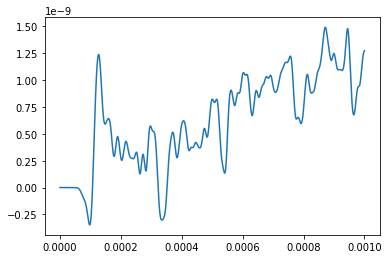

In [69]:
output1 = []
for h in range(total_step+1):
    output1.append(u[h][2*check_point1][0])
from matplotlib import pyplot as plt
time_list = []
for h in range(total_step+1):
    time_list.append(h*delta_t)
plt.plot(time_list, output1)
plt.show()

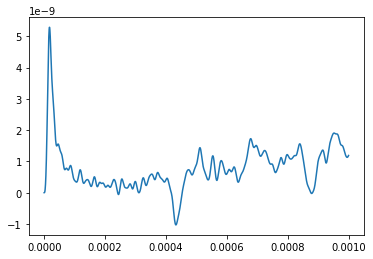

In [70]:
output2 = []
for h in range(total_step+1):
    output2.append(u[h][2*check_point2][0])
from matplotlib import pyplot as plt
time_list = []
for h in range(total_step+1):
    time_list.append(h*delta_t)
plt.plot(time_list, output2)
plt.show()

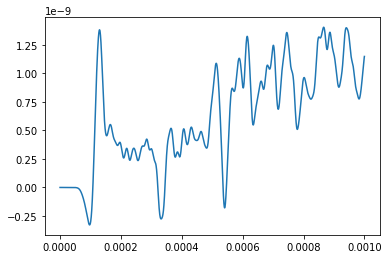

In [71]:
output3 = []
for h in range(total_step+1):
    output3.append(u[h][2*check_point3][0])
from matplotlib import pyplot as plt
time_list = []
for h in range(total_step+1):
    time_list.append(h*delta_t)
plt.plot(time_list, output3)
plt.show()